2604 ['G#', 'G', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'C', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'C', 'C', 'C', 'C', 'Am', 'F', 'F', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'F', 'F', 'Dm', 'Dm', 'Dm', 'Am', 'Dm', 'Dm', 'Dm', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Dm', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'Em', 'Em', 'Em', 'Em', 'Em', 'Dm', 'Dm', 'Dm', 'Dm', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Cm', 'G', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Am', 'G#', 'Cm', 'C', 'C', 'C', 'C', 'C', 'Cm', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Am', 'A', 'D', 'A', 'Am', 'C#m', 'E', 'E', 'E', 'E', 'E'

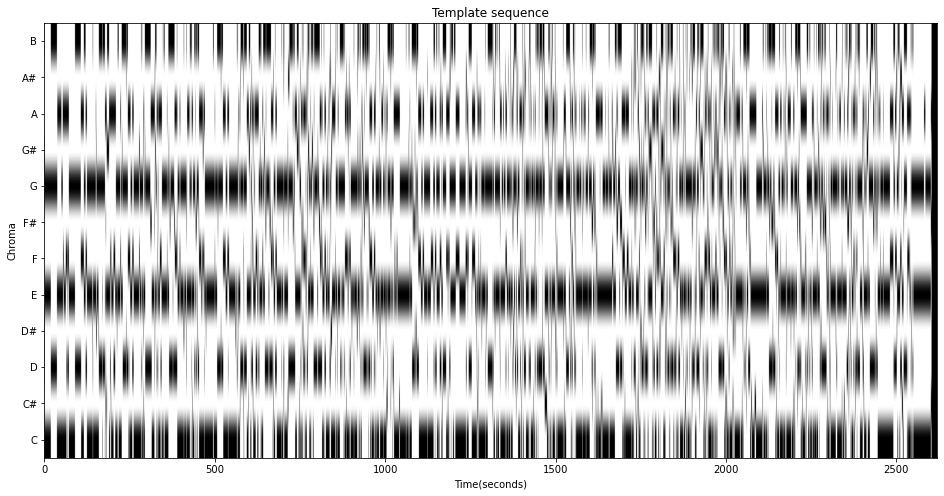

In [26]:
#Question 1

'''Implement the template based chord recognition algorithm. Define a function that takes as input the
path to a wav file and returns the estimated chords sequence labels.
The output must be a list

λ_pred = [λ_pred0, λpred_1, ..., λpred_N−1] (1)

where each element λpred_n is the predicted chord label for the time frame n. 
The length of the list depends on the feature rate, i.e., both on the window length and hop size 
used for the chromagram computation and on the downsampling factor, if feature downsampling is 
applied.

The chord templates to be considered are the major triads and the minor triads, leading to a total of 24 templates.
Once the function is defined in the notebook, test the function on the wav file Beatles LetItBe.wav,
available in /data/wav/ folder, and print or plot the output.

Explain in the report the idea behind the template-based chord recognition algorithm and detail each
step implemented in the code, including pre processing and post processing phases.
'''
#Import all packages

import os, sys
import math
from math import modf
import sys
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
%matplotlib inline

def generate_template_matrix(templates):
    template_matrix = np.zeros((12, 12 * templates.shape[1]))
    for shift in range(12):
        #np.roll: roll array elements along a given axis.
        template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)
    return template_matrix

def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Args:
        X: Feature sequence
        norm: The norm to be applied. '1', '2', 'max'
        threshold: An+ threshold below which the vector `v` used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm

    Returns:
        X_norm: Normalized feature sequence
    """
    K, N = X.shape
    X_norm = np.zeros((K, N))
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
                
    if norm == 'max':
        if v is None:
            v = np.ones(K)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    return X_norm

def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
    """
    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
    """
    # use expand dims to add one dimension to the window, from (L, ) to (1,L) 
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

def analysis_template_match(chromagram, templates, smoothing_window_length=None, smoothing_down_sampling=None,
                            Fs=22050, norm_chromagram='2', norm_output='2'):
    
    chroma_normalized = normalize_feature_sequence(chromagram, norm=norm_chromagram)
    if smoothing_window_length and smoothing_down_sampling:
        chroma_normalized, Fs_feat = smooth_downsample_feature_sequence(chroma_normalized, 
                                                                        down_sampling=smoothing_down_sampling,
                                                                        filt_len=smoothing_window_length, Fs=Fs)
    templates_normalized = normalize_feature_sequence(templates, norm=norm_chromagram)
    chord_similarity = np.matmul(templates_normalized.T, chroma_normalized)
    if norm_output:
         chord_similarity = normalize_feature_sequence(chord_similarity, norm=norm_output)
    
    chord_max = (chord_similarity == chord_similarity.max(axis=0)).astype(int)
    return chord_similarity, chord_max

def chordList(templates, template_sequence):
    template_sequence[template_sequence != 0] = 1 #evidenzia bene le note nella matrice in uscita
    chords = [] #inizializza la lista degli accordi
    
    #analizza ogni campione della matrice dell'audio e di quella di riferimento mettendoli a confronto
    #quando i campioni corrispondono assegna il nome dell'accordo all'array chords
    for i in range(template_sequence.shape[1]):
        for j in range(templates.shape[1]):
            if(np.array_equal(template_sequence[:,i], templates[:,j])): 
                #majorChords
                if(j==0):
                    chords.append("C")
                if(j==1):
                    chords.append("C#")
                if(j==2):
                    chords.append("D")
                if(j==3):
                    chords.append("D#")
                if(j==4):
                    chords.append("E")
                if(j==5):
                    chords.append("F")
                if(j==6):
                    chords.append("F#")
                if(j==7):
                    chords.append("G")
                if(j==8):
                    chords.append("G#")
                if(j==9):
                    chords.append("A")
                if(j==10):
                    chords.append("A#")   
                if(j==11):
                    chords.append("B")
                    
                #minorChords
                if(j==12):
                    chords.append("Cm")
                if(j==13):
                    chords.append("C#m")
                if(j==14):
                    chords.append("Dm")
                if(j==15):
                    chords.append("D#m")
                if(j==16):
                    chords.append("Em")
                if(j==17):
                    chords.append("Fm")
                if(j==18):
                    chords.append("F#m")
                if(j==19):
                    chords.append("Gm")
                if(j==20):
                    chords.append("G#m")
                if(j==21):
                    chords.append("Am")
                if(j==22):
                    chords.append("A#m")   
                if(j==23):
                    chords.append("Bm")
    return chords

#funzione che prende in ingresso un path di un segnale audio
def template_based_chord_recognigtion(audioPath):   
    #Generate Chord Template Matrix
    template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
    template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T
    templates = generate_template_matrix(np.concatenate((template_cmaj, template_cmin), axis=1))
  
    #Parameters
    Fs = 22050
    #Fs = 44100
    N = 4096
    #N = 8192
    H = 2048
    #H = 4096
    
    #Read audio
    x, Fs = librosa.load(audioPath, sr=Fs)
    
    #Algorithm
    X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
    X = np.abs(X) ** 2
    
    #logarithmic compression
    gamma = 0.1
    X = np.log(1 + gamma * np.abs(X) ** 2)
    
    #chromagram
    C = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, hop_length=H, n_fft=N, norm=None)
    
    #analize chords
    chords_sim, chords_max = analysis_template_match(C, templates, 
                                                 smoothing_window_length=None,
                                                 smoothing_down_sampling=None, 
                                                 Fs=Fs,
                                                 norm_chromagram='2', 
                                                 norm_output='max')
    # Compute normalized binary templates of analysis
    templates_normalized = normalize_feature_sequence(templates, norm='2')
    # by multipling the most probable chords by the templates (normalized), you obtain the sequence of chords chroma
    # by chroma
    
    #matrice contentente gli array degli accordi in binario
    template_sequence = np.matmul(templates_normalized, chords_max)
    #crea la matrice degli accordi in stringhe
    chords = chordList(templates, template_sequence)
    
    return chords, template_sequence, chords_max, templates

#Execute function
audioWav = os.path.join('data','wav', 'Beatles_LetItBe.wav')#read the path
chords_WAV, template_sequence, chords_max, templates = template_based_chord_recognigtion(audioWav)#ritorna gli accordi

#Plot
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
chord_label_maj = chroma_label
chord_label_min = [s + 'm' for s in chroma_label]
chord_labels = chord_label_maj + chord_label_min

plt.figure(figsize=(16, 8))
plt.yticks(np.array(np.arange(24)), chord_labels)
plt.title('Template sequence')
plt.xlabel('Time(seconds)')
plt.ylabel('Chroma')
im = plt.imshow(template_sequence, aspect='auto', origin='lower', cmap='gray_r', vmin=0, vmax=1)
print(len(chords_WAV), chords_WAV)




In [18]:
#Question 2
'''
Write a function to load and preprocess a reference annotation (or ground truth) file, saved in CSV
format. The function should take as input the path to a CSV file and produce as output a list of ground
truth chord labels, after suitable pre processing. The output must be a list

λgt = [λgt0, λgt1, ..., λgtN−1] (2)

where each element λgtn is the ground truth chord label for the time window n. 
The length of the list must be adapted to match the the feature rate.

The reference annotations stored in the CSV file are given in the form of labelled segments, each
specified as a triplet (start, end, λ) where start and end are expressed in seconds. To load the CSV file
check the csv library (distributed with Python) or Pandas library (needs to be installed).

In the preprocessing step you should
• convert the segment-based annotation into a frame-based label sequence adapted to the feature rate
used for the chroma sequence;
• convert the labels used in the annotation file to match the chord labels used for the chord recognition
algorithm in terms of enharmonic equivalence (i.e., Db = C# );

• reduce the chord label set used in the annotation to match the chord labels set used for the chord
recognition algorithm (i.e., DMaj6 → D); for this step you can choose any reduction strategy.

Once the function is defined in the notebook, test the function on the CSV file Beatles LetItBe.csv,
available in /data/csv/ folder, and print or plot the output.
Explain in the report each step of the preprocessing phase, focusing in particular on the reduction
strategy of the chord label set.
'''

import csv 
Fs = 22050
def chordsFromCsv(path):
    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        chords = []
        i = 0;
        note = ['C','D','E','F','G','A','B']

        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                #print(math.trunc(float(row[1])*Fs), chords_WAV[math.trunc(float(row[1])*Fs)])
                #print(math.trunc(float(row[1])*Fs))
                
                
                if "min" in row[2].split(':'):
                    temp = row[2].split(':')[0]+'m'
                else:
                    temp = row[2].split(':')[0]
                
                chords.append(temp.split('/')[0])

        for e in chords:
            if 'b' in e:
                chords[i]=note[note.index(chords[i][0])-1]+'#'
            i += 1
            
    return chords

audioCSV='data/csv/Beatles_LetItBe.csv' 
chords_CSV =chordsFromCsv(audioCSV);

print(len(chords_CSV), chords_CSV)
'''
import csv 
chroma_length = len(chords_max) 
gt_label_matrix = np.zeros((24, chroma_length)) 

def chordsFromCsv(path, chroma_length):
    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        chords = []
        i = 0;
        note = ['C','D','E','F','G','A','B']
        song_duration = 0 
        gt_labels = [] 
        segment_durations = [] 
        boolean = True 

        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                if "min" in row[2].split(':'):
                    temp = row[2].split(':')[0]+'m'
                else:
                    temp = row[2].split(':')[0]
                
                chords.append(temp.split('/')[0])#durations 
                segment_durations.append(float(row[1])-float(row[0])) 
             
            song_duration = row[1] 
        print(len(chords))
        
        for e in chords:
            if 'b' in e:
                chords[i]=note[note.index(chords[i][0])-1]+'#'
            i += 1
            
        #converting to segment based to frame based list 
        frame_per_second = chroma_length/float(song_duration) 
        index = 0 
        for duration in segment_durations: 
            gt_frame = duration*frame_per_second 
            gt_frame = round(gt_frame, 1) 
            #gt_frame = math.trunc(gt_frame, 1) 
            chord_name = chords[index] 
            frame_fraz, frame_int = modf(gt_frame) 
             
            if frame_fraz < 0.5 or frame_fraz > 0.5: 
                gt_frame = round(gt_frame) 
            elif frame_fraz == 0.5 and boolean == True: 
                gt_frame = int(frame_int) 
                boolean = False 
            elif frame_fraz == 0.5 and boolean == False: 
                gt_frame = int(frame_int+1) 
                boolean = True 
                 
            for frame in range(gt_frame): 
                gt_labels.append(chord_name) 
                 
            index += 1 
             
 
        #print(gt_labels) 
        print(len(gt_labels))
            
    return gt_labels, chords

audioCSV='data/csv/Beatles_LetItBe.csv' 
chords_CSV =chordsFromCsv(audioCSV, chroma_length);

#print(len(chords_CSV), chords_CSV)

'''
'''
Ric Plando, [17/12/2021 16.48]
import csv 
 
from math import modf 
 
chroma_length = len(input_list) 
gt_label_matrix = np.zeros((24, chroma_length)) 
 
def load_ground_truth(csv, chroma_length): 
 
    with open('data/csv/Beatles_HereComesTheSun.csv') as csv_file: 
        csv_reader = csv.reader(csv_file, delimiter=',') 
        line_count = 0 
        list = [] 
        i = 0 
        notes = ['C','D','E','F','G','A','B'] 
        chord_note = '' 
        song_duration = 0 
        gt_labels = [] 
        segment_durations = [] 
        boolean = True 
 
        for row in csv_reader: 
            if line_count == 0: 
                line_count += 1 
            else: 
                if "min" in row[2].split(':'): 
                    chord_note = row[2].split(':')[0]+'m' 
                else: 
                    chord_note = row[2].split(':')[0] 
                list.append(chord_note.split('/')[0]) 
                #durations 
                segment_durations.append(float(row[1])-float(row[0])) 
             
            song_duration = row[1] 
        print(len(list)) 
 
        #to convert flats into equivalent enharmonics             
        for e in list: 
            if 'b' in e: 
                #print(note[note.index(tro[i][0])-1]+'#') 
                list[i]=notes[notes.index(list[i][0])-1]+'#' 
            i += 1 
             
        #converting to segment based to frame based list 
        frame_per_second = chroma_length/float(song_duration) 
        index = 0 
        for duration in segment_durations: 
            gt_frame = duration*frame_per_second 
            gt_frame = round(gt_frame, 1) 
            #gt_frame = math.trunc(gt_frame, 1) 
            chord_name = list[index] 
            frame_fraz, frame_int = modf(gt_frame) 
             
            if frame_fraz < 0.5 or frame_fraz > 0.5: 
                gt_frame = round(gt_frame) 
            elif frame_fraz == 0.5 and boolean == True: 
                gt_frame = int(frame_int) 
                boolean = False 
            elif frame_fraz == 0.5 and boolean == False: 
                gt_frame = int(frame_int+1) 
                boolean = True 
                 
            for frame in range(gt_frame): 
                gt_labels.append(chord_name) 
                 
            index += 1 
             
 
        #print(gt_labels) 
        print(len(gt_labels)) 
     
    return gt_labels 
 
gt_chroma = load_ground_truth(csv, chroma_length)
'''

159 ['C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'F', 'C', 'G', 'F', 'C', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'F', 'C', 'G', 'F', 'C']


'\nRic Plando, [17/12/2021 16.48]\nimport csv \n \nfrom math import modf \n \nchroma_length = len(input_list) \ngt_label_matrix = np.zeros((24, chroma_length)) \n \ndef load_ground_truth(csv, chroma_length): \n \n    with open(\'data/csv/Beatles_HereComesTheSun.csv\') as csv_file: \n        csv_reader = csv.reader(csv_file, delimiter=\',\') \n        line_count = 0 \n        list = [] \n        i = 0 \n        notes = [\'C\',\'D\',\'E\',\'F\',\'G\',\'A\',\'B\'] \n        chord_note = \'\' \n        song_duration = 0 \n        gt_labels = [] \n        segment_durations = [] \n        boolean = True \n \n        for row in csv_reader: \n            if line_count == 0: \n                line_count += 1 \n            else: \n                if "min" in row[2].split(\':\'): \n                    chord_note = row[2].split(\':\')[0]+\'m\' \n                else: \n                    chord_note = row[2].split(\':\')[0] \n                list.append(chord_note.split(\'/\')[0]) \n              

In [93]:
#Question 3
'''
Propose a metric for evaluating the template based chord recognition algorithm. 
A metric

m = f(λ_pred,λ_gt) (3)

is a scalar number that expresses how good is the algorithm in performing the task of chord recognition.
The proposed metric should have higher values when the chord recognition algorithm is able to predict
correctly the ground truth chords most of the times, lower values if the chord recognition algorithm often
fails at recognising the chords.

Write a function that takes as input the list of predicted chord labels, the list of ground truth chord
labels and computes the proposed metric value. The two input lists must have same length and the
output must be a scalar value.

Once the function is defined in the notebook, test the function on the two lists of predicted and ground
truth chord labels computed in Question 1 and Question 2.

In the report write a formal definition of the proposed metric and thoroughly explain the idea behind
the proposal. Can you imagine a musically informed strategy that weights differently mismatch errors of
the chord recognition algorithm?
'''

notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

#trueChords=chordsFromCsv(audioCSV, chroma_length);
chordsCSV=chordsFromCsv(audioCSV)
chordsCSV_notes = np.zeros((12, len(chordsCSV)))

#recognizedChords=chordList(templates, template_sequence);
#da ultimare

recognizedChords=['C#', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'F', 'C', 'G', 'F', 'C', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'Am', 'E', 'F', 'C', 'C', 'G', 'F', 'C', 'F', 'C', 'G', 'F', 'C']

numChords=len(chordsCSV)
num_of_error=0
imp_errors=[]

#converti csv in accordi
for i in range(len(chordsCSV)):
        for j in range(templates.shape[1]):
            
                #majorChords
                if(chordsCSV[i] == 'C'):
                    chordsCSV_notes[:, i] = templates[:,0]
                    
                if(chordsCSV[i] == 'C#'):
                    chordsCSV_notes[:, i] = templates[:,1]
                    
                if(chordsCSV[i] == 'D'):
                    chordsCSV_notes[:, i] = templates[:,2]
                    
                if(chordsCSV[i] == 'D#'):
                    chordsCSV_notes[:, i] = templates[:,3]
                    
                if(chordsCSV[i] == 'E'):
                    chordsCSV_notes[:, i] = templates[:,4]
                    
                if(chordsCSV[i] == 'F'):
                    chordsCSV_notes[:, i] = templates[:,5]
                    
                if(chordsCSV[i] == 'F#'):
                    chordsCSV_notes[:, i] = templates[:,6]
                    
                if(chordsCSV[i] == 'G'):
                    chordsCSV_notes[:, i] = templates[:,7]
                    
                if(chordsCSV[i] == 'G#'):
                    chordsCSV_notes[:, i] = templates[:,8]
                    
                if(chordsCSV[i] == 'A'):
                    chordsCSV_notes[:, i] = templates[:,9]
                    
                if(chordsCSV[i] == 'A#'):
                    chordsCSV_notes[:, i] = templates[:,10]
                    
                if(chordsCSV[i] == 'B'):
                    chordsCSV_notes[:, i] = templates[:,11]
                
                #minorChords
                if(chordsCSV[i] == 'Cm'):
                    chordsCSV_notes[:, i] = templates[:,12]
                    
                if(chordsCSV[i] == 'C#m'):
                    chordsCSV_notes[:, i] = templates[:,13]
                    
                if(chordsCSV[i] == 'Dm'):
                    chordsCSV_notes[:, i] = templates[:,14]
                    
                if(chordsCSV[i] == 'D#m'):
                    chordsCSV_notes[:, i] = templates[:,15]
                    
                if(chordsCSV[i] == 'Em'):
                    chordsCSV_notes[:, i] = templates[:,16]
                    
                if(chordsCSV[i] == 'Fm'):
                    chordsCSV_notes[:, i] = templates[:,17]
                    
                if(chordsCSV[i] == 'F#m'):
                    chordsCSV_notes[:, i] = templates[:,18]
                    
                if(chordsCSV[i] == 'Gm'):
                    chordsCSV_notes[:, i] = templates[:,19]
                    
                if(chordsCSV[i] == 'G#m'):
                    chordsCSV_notes[:, i] = templates[:,20]
                    
                if(chordsCSV[i] == 'Am'):
                    chordsCSV_notes[:, i] = templates[:,21]
                    
                if(chordsCSV[i] == 'A#m'):
                    chordsCSV_notes[:, i] = templates[:,22]
                    
                if(chordsCSV[i] == 'Bm'):
                    chordsCSV_notes[:, i] = templates[:,23] 
                    
#print(chordsCSV_notes)               
error = []
#print(template_sequence.shape)
#print(chordsCSV_notes.shape)

'''
for i in range(chordsCSV_notes.shape[1]):#guardo le colonne
    c = 0
    for j in range(chordsCSV_notes.shape[0]):#guardo le righe
        #if(chordsCSV_notes[j,i] == 1 and chordsCSV_notes[j,i] == template_sequence[j,i]):
                c += 1 #conto il numero di note in comune nella stessa posizione             
    #inserisco i gradi di errore nella lista degli errori
    if(c == 3):
        error.append(0)
    if(c == 2):
        error.append(1)
    if(c == 1):
        error.append(2)
    if(c == 0):
        error.append(3)
        
print(error)
#similarity = 100 - (100*(np.sum(error)/(3*len(error)))) #where 3 è il grado massimo di errore.
#print(similarity)
'''
'''                    
for chord in range(len(chordsCSV)):
    #print (chord,trueChords[chord])
    if(chordsCSV[chord]!=recognizedChords[chord]):
        
        print(chord,chordsCSV[chord]);
        #imp_errors.append(abs(notes.index(chordsCSV[chord])- notes.index(recognizedChords[chord])));
        #calcolare la quantita dell'errore facendo la differenza di semitoni

if (num_of_error!=0):
    
    #stampa la percentuale di successo, confronta se le due liste sono uguali
    #perc_success1=math.trunc((100-((num_of_error/numChords)*100)));
    perc_success1=math.trunc((100-((num_of_error/numChords)*100)));
    print(perc_success1);
    
    #stampa la percentuale di successo 2 trovando l'imp err medio e trovando di quanti semitonin si discosta dall'accordo corretto
    imp_errors_med=sum(imp_errors)/len(imp_errors);
    perc_success2=math.trunc((100-((imp_errors_med/11)*100)));
    print(perc_success1,perc_success2);
    
else:
    print(100);# le due liste sono identiche
'''

(12, 2620)
(12, 159)


"                    \nfor chord in range(len(chordsCSV)):\n    #print (chord,trueChords[chord])\n    if(chordsCSV[chord]!=recognizedChords[chord]):\n        \n        print(chord,chordsCSV[chord]);\n        #imp_errors.append(abs(notes.index(chordsCSV[chord])- notes.index(recognizedChords[chord])));\n        #calcolare la quantita dell'errore facendo la differenza di semitoni\n\nif (num_of_error!=0):\n    \n    #stampa la percentuale di successo, confronta se le due liste sono uguali\n    #perc_success1=math.trunc((100-((num_of_error/numChords)*100)));\n    perc_success1=math.trunc((100-((num_of_error/numChords)*100)));\n    print(perc_success1);\n    \n    #stampa la percentuale di successo 2 trovando l'imp err medio e trovando di quanti semitonin si discosta dall'accordo corretto\n    imp_errors_med=sum(imp_errors)/len(imp_errors);\n    perc_success2=math.trunc((100-((imp_errors_med/11)*100)));\n    print(perc_success1,perc_success2);\n    \nelse:\n    print(100);# le due liste sono

In [ ]:
#Question 4
'''
Compute the proposed metric for the remaining 3 songs:
• audio Beatles HereComesTheSun.wav, CSV Beatles HereComesTheSun.csv
• audio Beatles PennyLane.wav, CSV Beatles PennyLane.csv
• audio Beatles ObLaDiObLaDa.wav, CSV Beatles ObLaDiObLaDa.csv
all contained in folders /data/wav/ and /data/csv/. Print or plot the metric values.
'''

In [ ]:
#Question 5
'''
Analyse how algorithm parameters affect the performance of the templated based chord recognition
algorithm.
Given one algorithm parameter (i.e., smoothing filter length L), choose a range of 3 possible values
for it (i.e.,L = [0, 10, 20] ). 
For each value of the parameter, compute the predicted labels and the correspondent metric value for each song.
This produces a list of 3 metric values for each song.

Plot the results for all songs in a figure where the x-axis corresponds to the parameter values, the
y-axis corresponds to metric values. An example of the plot is in Figure 1.

Repeat this for at least 3 different algorithm parameters. 
Note that in every experiment you need to change only one parameter value at a time, while the others must be fixed.

Show the 3 plots both in the Jupyter Notebook and in the report. 
What considerations can you do from the 3 plots that you have? 
Are some algorithm parameters affecting the results more than others?
Comment the results in the report.
'''